In [2]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from scipy import stats
from scipy.stats.distributions import beta
from scipy.special import beta as beta_func

import pymc3 as pm

import pandas as pd

import datetime

import seaborn as sns

import folium
from folium.plugins import MarkerCluster

from IPython.display import HTML

import time

import csv

plt.style.use('bmh')

In [3]:
"""This Document is an exploration of the traviling salesman problem. Every plotted dot in the graph below is a
city. The goal is to optimize a path to each city with the stipulation that every 10th city traveled to must
be a prime numbered city or the distance will have a 10% penelty applied. The methods applied here are a basic 
nearest neighbor approach, a nearest neighbor with probabilistic variations, and nearest neighbor with clustering
and/or probablitistic variations."""

'This Document is an exploration of the traviling salesman problem. Every plotted dot in the graph below is a\ncity. The goal is to optimize a path to each city with the stipulation that every 10th city traveled to must\nbe a prime numbered city or the distance will have a 10% penelty applied. The methods applied here are a basic \nnearest neighbor approach, a nearest neighbor with probabilistic variations, and nearest neighbor with clustering\nand/or probablitistic variations.'

In [4]:
data = pd.read_csv('cities.csv')

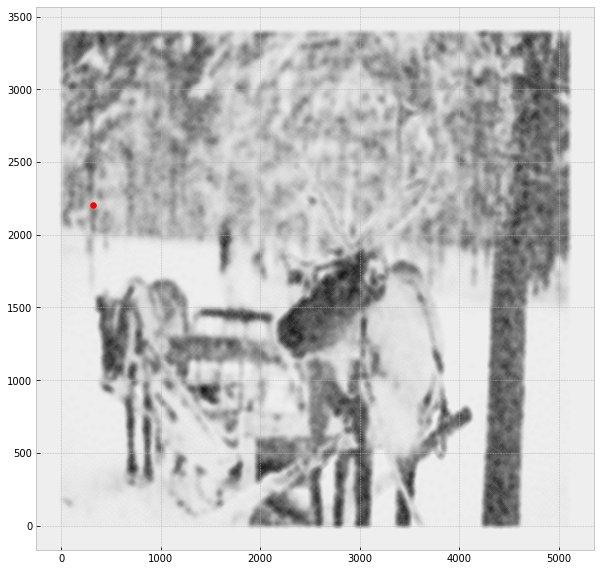

In [5]:
ID = data['CityId']
x = data['X']
y = data['Y']

full_data_dict = {}
for i, val in enumerate(ID):
    full_data_dict[val] = (x[i], y[i])

plt.figure(figsize=(10,10))
plt.scatter(x,y, alpha=.008, color='k')
plt.scatter(x[0],y[0], alpha=1, color='r');

In [6]:
n = len(ID) -1

def prime_nums(n):
    """This function finds prime numbers up to a given value."""
    primes = [2,3,5,7,11,13,17,19,23,29,31,37,41]
    nums = np.arange((primes[-1]+1),n)
    for i in primes:
        nums = nums[nums%i!=0]
    
    pos = primes[-1] + 1
    
    while len(nums)>0:
        pos = nums[0]
        
        if pos % primes[-1] != 0:
            primes.append(pos)
            nums = nums[nums%pos!=0]
        else:
            nums.remove(pos)
    
    return np.array(primes)

In [7]:
primes = prime_nums(n)

(3443.7602611409102, 2809.5893399597103)
(3454.1581977117198, 2820.0530112481106)


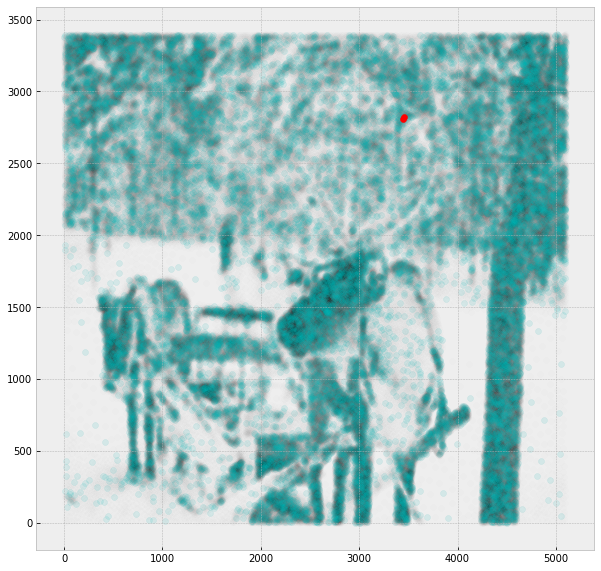

In [8]:
ID_prime = [ID[i] for i in primes]
x_prime = [x[i] for i in primes]
y_prime = [y[i] for i in primes]

prime_dict = {}
for i, val in enumerate(ID_prime):
    prime_dict[val] = (x_prime[i],y_prime[i])

plt.figure(figsize=(10,10))
plt.scatter(x,y, alpha=.008, color='k')
plt.scatter(x_prime,y_prime, alpha=.1, color='c')
plt.scatter(prime_dict[2.0][0],prime_dict[2.0][1], alpha=1, color='r')
plt.scatter(prime_dict[135077.0][0], prime_dict[135077.0][1], alpha=1, color='r');
print(prime_dict[135077.0])
print(prime_dict[2.0])

In [9]:
#start_time = time.time()
#prime_nums(1000000)
#print ("My program took", time.time() - start_time, "to run")

In [10]:
data_prime = np.array([ID_prime, x_prime, y_prime])
data_prime

array([[  2.00000000e+00,   3.00000000e+00,   5.00000000e+00, ...,
          1.97753000e+05,   1.97759000e+05,   1.97767000e+05],
       [  3.45415820e+03,   4.68809930e+03,   2.47423088e+03, ...,
          3.91607467e+03,   1.39080520e+03,   2.99423095e+03],
       [  2.82005301e+03,   2.93589806e+03,   1.43551465e+03, ...,
          2.80951844e+03,   8.99598564e+02,   1.93176434e+03]])

In [11]:
def nearest_neighbor(data, start):
    '''This function uses the nearest neighbor algorithm to find the closest city.'''
    steps = [start]
    ID = np.array(data[0])
    x = np.array(data[1])
    y = np.array(data[2])
    #print(ID)

    data_dict = {}
    for i, val in enumerate(data[0]):
        data_dict[val] = (x[i],y[i])

    while len(steps) != len(data[0]):
        pos_id = steps[-1]
        pos_x, pos_y = data_dict[int(pos_id)]
        options = []
        
        # Find at least one non-current-position city in the radius of current position
        count = 1
        while len(options) < 2:
            radius = count * 20
            options = ID[np.sqrt((x - pos_x)**2 + (y - pos_y)**2)<radius]
            count += 1
        options = np.array(options)
        
        # Delete current position from available options
        options_index = np.where(options==np.array(pos_id))
        options = np.delete(options, options_index[0])
        ID_index = np.where(ID==np.array(pos_id))
        ID = np.delete(ID, ID_index[0])
        x = np.delete(x, ID_index[0])
        y = np.delete(y, ID_index[0])
        
        distances = []      
        dist_dict = {}
        
        for i in options:
            distance = (np.sqrt((data_dict[i][0] - pos_x)**2 + (data_dict[i][1] - pos_y)**2))
            dist_dict[distance] = i
            distances.append(distance)
            
        #print(dist_dict)
        steps.append(dist_dict[min(distances)])
        if len(steps)%1000 == 0:
            print('{}% Complete'.format(round(100.0*(len(steps)/len(data[0])))), end='\r', flush=True)

    steps.append(steps[0])
    return steps

In [12]:
#steps = nearest_neighbor(data_prime)

In [13]:
# steps

# prime_xs = [prime_dict[i][0] for i in steps]
# prime_ys = [prime_dict[i][1] for i in steps]

# plt.plot(prime_xs,prime_ys);

In [14]:
full_data = np.array([ID, x, y])
full_dict = {}
for i, val in enumerate(ID):
    full_dict[val] = (x[i],y[i])
    
full_steps = nearest_neighbor(full_data, 0)

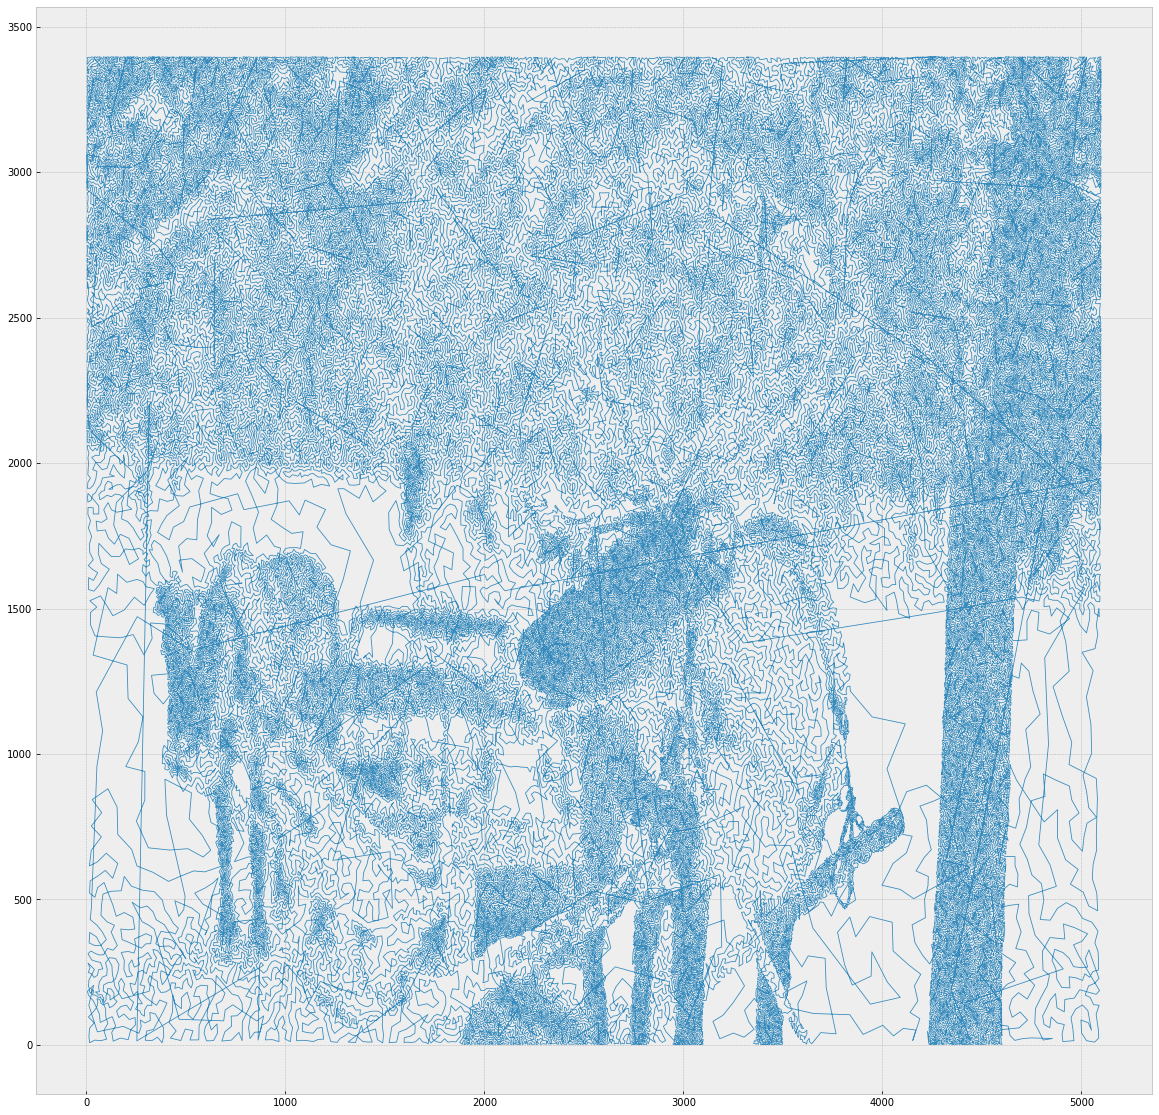

In [15]:
full_data = np.array([ID, x, y])
full_dict = {}
for i, val in enumerate(ID):
    full_dict[val] = (x[i],y[i])
    
full_xs = [full_dict[i][0] for i in full_steps]
full_ys = [full_dict[i][1] for i in full_steps]


fig, ax = plt.subplots(figsize = (20,20))
ax.plot(full_xs,full_ys, alpha =1, linewidth=.8);

In [16]:
def path_dist(path, data_dict, primes):
    """This function calculates the path distance based on the competition's scoring system (you must travel to
    a prime city every 10 steps or your distance is 10% longer)."""
    total_dist = 0
    step_dists = []
    for i in range(1,len(path)):
        distance_factor = 1
        if i % 10 == 0 and path[i] not in primes:
            distance_factor = 1.1
        if i % 200 == 0:
            print('{}% Complete'.format(round(100.0*(len(step_dists)/len(path)), 1)), end='\r', flush=True)
        step_dist = distance_factor * ((data_dict[path[i]][0] - data_dict[path[i-1]][0])**2 + 
                                        (data_dict[path[i]][1] - data_dict[path[i-1]][1])**2)**.5
        step_dists.append(step_dist)
        total_dist += step_dist
    return total_dist

In [17]:
full_path_dist = path_dist(full_steps, full_data_dict, ID_prime)

In [18]:
full_path_dist / 1533440.01

1.182080911803741

In [19]:
def comparision_prob(distances):
    '''This fuction takes distances and returns the minimum travel distanced. This can be adjusted to include
    a probabilistic component.'''
    if len(distances) == 1:
        return distances[0]
    else:
        min_dist = min(distances)
        distances.remove(min_dist)
        second_min_dist = min(distances)
        random_dist = distances[np.random.randint(low=0,high=len(distances))]

        prob = second_min_dist / (second_min_dist + min_dist)
        prob = 0

        if np.random.random() > prob:
            return random_dist
        else:
            return min_dist

In [20]:
def optimized_nearest_neighbor(data, start):
    ''' This is an adjusted nearest neighbor algorithm that takes into account the competition rules for prime
    numbers.'''
    steps = [start]
    ID = np.array(data[0])
    x = np.array(data[1])
    y = np.array(data[2])
    
    primes = prime_nums(len(ID))
    
    data_dict = {}
    for i, val in enumerate(data[0]):
        data_dict[val] = (x[i],y[i])

    while len(steps) != len(data[0]):
        pos_id = steps[-1]
        pos_x, pos_y = data_dict[int(pos_id)]
        options = []
        
        count = 1
        while len(options) < 2:
            radius = count * 20
            options = ID[np.sqrt((x - pos_x)**2 + (y - pos_y)**2)<radius]
            count += 1
        options = np.array(options)
        
        options_index = np.where(options==np.array(pos_id))
        options = np.delete(options, options_index[0])
        
        ID_index = np.where(ID==np.array(pos_id))
        ID = np.delete(ID, ID_index[0])
        x = np.delete(x, ID_index[0])
        y = np.delete(y, ID_index[0])
        
        distances = []
        dist_dict = {}
        
        for i in options:
            if len(steps) %10 != 9:
                distance = (np.sqrt((data_dict[i][0] - pos_x)**2 + (data_dict[i][1] - pos_y)**2))
                dist_dict[distance] = i
                distances.append(distance)
            else:
                if i in primes:
                    distance = (np.sqrt((data_dict[i][0] - pos_x)**2 + (data_dict[i][1] - pos_y)**2))
                else:
                    distance = 1.1*(np.sqrt((data_dict[i][0] - pos_x)**2 + (data_dict[i][1] - pos_y)**2))
                dist_dict[distance] = i
                distances.append(distance)
            
        steps.append(dist_dict[min(distances)])
        
        if len(steps)%10000 == 0:
            print('{}% Complete'.format(round(100.0*(len(steps)/len(data[0])),1)), end='\r', flush=True)

    steps.append(steps[0])
    return steps

In [21]:
optimized_steps = optimized_nearest_neighbor(full_data, 0)

In [22]:
opt_path_dist = path_dist(optimized_steps, full_data_dict, ID_prime)

In [23]:
full_path_dist - opt_path_dist

-11.209115734323859

In [24]:
def probabalistic_optimized_nearest_neighbor(data, freq, start):
    ''' This is an adjusted nearest neighbor algorithm, this uses probability to create variations in the path,
    that is the closest city will not always be chosen, with some probability based on how close the second 
    closest city is.'''
    steps = [start]
    ID = np.array(data[0])
    x = np.array(data[1])
    y = np.array(data[2])
    
    primes = prime_nums(len(ID))
    
    data_dict = {}
    for i, val in enumerate(data[0]):
        data_dict[val] = (x[i],y[i])

    while len(steps) != len(data[0]):
        pos_id = steps[-1]
        pos_x, pos_y = data_dict[int(pos_id)]
        options = []
        
        count = 1
        while len(options) < 2:
            radius = count * 20
            options = ID[np.sqrt((x - pos_x)**2 + (y - pos_y)**2)<radius]
            count += 1
        options = np.array(options)
        
        options_index = np.where(options==np.array(pos_id))
        options = np.delete(options, options_index[0])
        
        ID_index = np.where(ID==np.array(pos_id))
        ID = np.delete(ID, ID_index[0])
        x = np.delete(x, ID_index[0])
        y = np.delete(y, ID_index[0])
        
        distances = []
        dist_dict = {}
        
        for i in options:
            if len(steps) %10 != 9:
                distance = (np.sqrt((data_dict[i][0] - pos_x)**2 + (data_dict[i][1] - pos_y)**2))
                dist_dict[distance] = i
                distances.append(distance)
            else:
                if i in primes:
                    distance = (np.sqrt((data_dict[i][0] - pos_x)**2 + (data_dict[i][1] - pos_y)**2))
                else:
                    distance = 1.1*(np.sqrt((data_dict[i][0] - pos_x)**2 + (data_dict[i][1] - pos_y)**2))
                dist_dict[distance] = i
                distances.append(distance)
        
        
        if np.random.random() < freq and len(steps)<180000:
            steps.append(dist_dict[comparision_prob(distances)])
        else:
            steps.append(dist_dict[min(distances)])
        
        if len(steps)%1000 == 0:
            print('{}% Complete'.format(round(100.0*(len(steps)/len(data[0])))), end='\r', flush=True)

    steps.append(steps[0])
    return steps

In [25]:
prob_steps = probabalistic_optimized_nearest_neighbor(full_data, .001, 0)

In [26]:
prob_path_dist = path_dist(prob_steps, full_data_dict, ID_prime)

In [27]:
prob_path_dist - full_path_dist

3464.7724275270011

In [30]:
full_path_dist

1812650.1652171377

In [31]:
prob_path_dist

1816114.9376446647

In [32]:
166570.68279184727

166570.68279184727

In [33]:
'''This runs the probabilistic path function multiple times and looks for improved paths.'''

shortest_dist = prob_path_dist
count = 0
improvements = 0


for i in range(3):
    start_point = 0
    freq = .05
    
    trial_path = probabalistic_optimized_nearest_neighbor(full_data, freq, start_point)
    #trial_path = optimized_nearest_neighbor(full_data)
    trial_dist = path_dist(trial_path, full_data_dict, ID_prime)
    
    if trial_dist < shortest_dist:
        shortest_dist = trial_dist
        shortest_path = trial_path
        improvements += 1
    count += 1
    print('{} Trials, {} Improvements. Path distance = {}, starting from = {}'.format(count, improvements, round(trial_dist), start_point), end='\n\r', flush=True)
    
    

1 Trials, 0 Improvements. Path distance = 1956024.0, starting from = 0
2 Trials, 0 Improvements. Path distance = 2019680.0, starting from = 0
3 Trials, 0 Improvements. Path distance = 2087307.0, starting from = 0


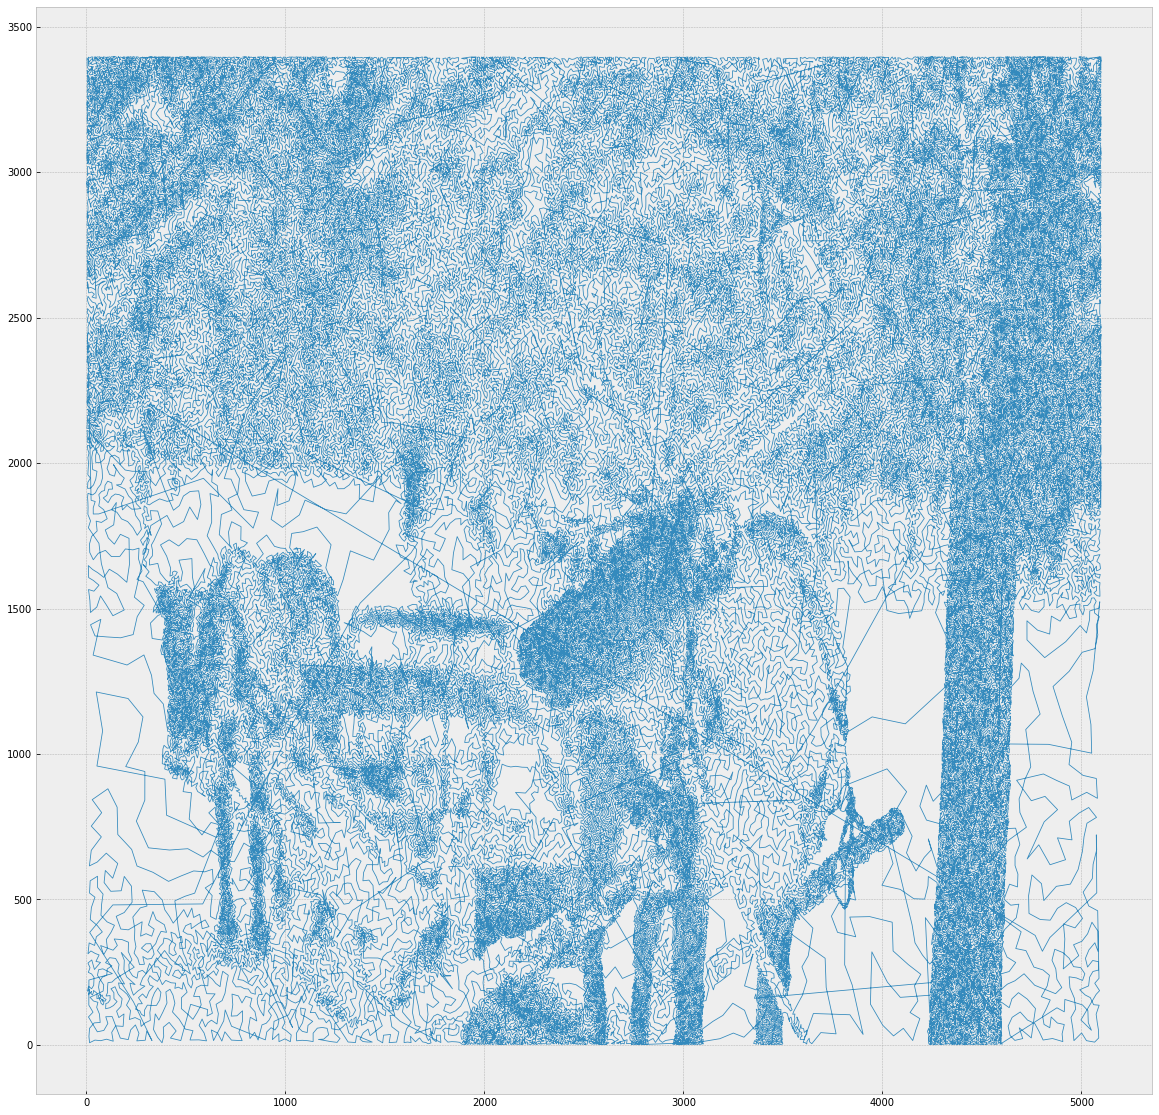

In [34]:
steps = trial_path

full_xs = [full_dict[i][0] for i in steps]
full_ys = [full_dict[i][1] for i in steps]

end = None

fig, ax = plt.subplots(figsize = (20,20))
ax.plot(full_xs[:end],full_ys[:end], alpha =1, linewidth=.8);

In [30]:
shortest_dist

1813611.1788360996

In [31]:
prob_path_dist

1813611.1788360996

In [35]:
def probabalistic_optimized_nearest_neighbor1(data, freq, start):
    """This function uses probabilitic nearest neighbor and is optimized with the competition rules for 
    prime numbered cities."""
    steps = [start]
    ID = np.array(data[0])
    x = np.array(data[1])
    y = np.array(data[2])
    
    primes = prime_nums(len(ID))
    
    data_dict = {}
    for i, val in enumerate(data[0]):
        data_dict[val] = (x[i],y[i])

    while len(steps) < len(data[0]) * .98:
        pos_id = steps[-1]
        pos_x, pos_y = data_dict[int(pos_id)]
        options = []
        
        count = 1
        while len(options) < 2:
            radius = count * 20
            options = ID[np.sqrt((x - pos_x)**2 + (y - pos_y)**2)<radius]
            count += 1
        options = np.array(options)
        
        options_index = np.where(options==np.array(pos_id))
        options = np.delete(options, options_index[0])
        
        ID_index = np.where(ID==np.array(pos_id))
        ID = np.delete(ID, ID_index[0])
        x = np.delete(x, ID_index[0])
        y = np.delete(y, ID_index[0])
        
        distances = []
        dist_dict = {}
        
        for i in options:
            if len(steps) %10 != 9:
                distance = (np.sqrt((data_dict[i][0] - pos_x)**2 + (data_dict[i][1] - pos_y)**2))
                dist_dict[distance] = i
                distances.append(distance)
            else:
                if i in primes:
                    distance = (np.sqrt((data_dict[i][0] - pos_x)**2 + (data_dict[i][1] - pos_y)**2))
                else:
                    distance = 1.1*(np.sqrt((data_dict[i][0] - pos_x)**2 + (data_dict[i][1] - pos_y)**2))
                dist_dict[distance] = i
                distances.append(distance)
        
        
        if np.random.random() < freq and len(steps)<180000:
            steps.append(dist_dict[comparision_prob(distances)])
        else:
            steps.append(dist_dict[min(distances)])
        
        if len(steps)%1000 == 0:
            print('{}% Complete'.format(round(100.0*(len(steps)/len(data[0])))), end='\r', flush=True)

    steps.append(steps[0])
    return steps

In [73]:
def clustered_NN(data, start, radius):
    '''This function uses nearest neighbor but ensures that a smaller radius of cities are all traveled to before
    expanding the search area.'''
    steps = [start]
    ID = np.array(data[0])
    x = np.array(data[1])
    y = np.array(data[2])
    
    primes = prime_nums(len(ID))
    
    data_dict = {}
    for i, val in enumerate(data[0]):
        data_dict[val] = (x[i],y[i])
        
    start_x = data_dict[start][0]
    start_y = data_dict[start][1]

    while len(steps) != len(data[0]):
        pos_id = steps[-1]
        pos_x, pos_y = data_dict[int(pos_id)]
        cluster = []
        
        count = 1
        while len(cluster) < 2:
            radius_0 = 2*count * radius
            cluster = ID[np.sqrt((x - pos_x)**2 / 3 + (y - pos_y)**2) / 2.5<radius_0]
#             if pos_y >= 2000 and len(ID[y > 2000]) > 1:
#                 cluster = ID[y > 2000]
#             elif pos_x > 4000 and len(ID[x > 4000]) > 1:
#                 cluster = ID[x > 4000]
#             else:
#                 cluster = ID[np.sqrt((x - pos_x)**2 / 2 + (y - pos_y)**2) / 4<radius_0]
            count += 1
        cluster_ID = np.array(cluster)
        #return cluster_ID
        
        location = np.isin(ID,cluster)
        ID_Bool = location
        cluster_x = x[ID_Bool]
        cluster_y = y[ID_Bool]
        cluster_data = [cluster_ID, cluster_x, cluster_y]
        
        if len(steps) / len(data[0]) < 0:
            cluster_steps = probabalistic_optimized_nearest_neighbor1(cluster_data, .01, pos_id)
        else:
            cluster_steps = probabalistic_optimized_nearest_neighbor(cluster_data, .01, pos_id)
        steps = steps + cluster_steps[1:-1]
        
#         last_step_index = np.where(cluster == steps[-1])
#         leftovers = np.isin(cluster, cluster_steps)
#         leftovers_index = np.where(leftovers == False)
#         cluster = np.delete(cluster, last_step_index)
#         cluster = np.delete(cluster, leftovers_index)
        
        #print(steps)
        location = np.isin(ID, steps[:-1])
        ID_Bool = location
        ID_index = np.where(ID_Bool==True)
        ID = np.delete(ID, ID_index)
        x = np.delete(x, ID_index)
        y = np.delete(y, ID_index)
        
        print('{}% Complete'.format(round(100.0*(len(steps)/len(data[0])),1)), end='\r\n', flush=True)
        #print(len(ID))
    steps.append(steps[0])
    return steps

In [74]:
cluster_steps = clustered_NN(full_data, start=0, radius=10)

0.1% Complete
0.1% Complete
0.2% Complete
0.2% Complete
0.2% Complete
0.3% Complete
0.3% Complete
0.3% Complete
0.3% Complete
0.4% Complete
0.4% Complete
0.4% Complete
0.5% Complete
0.5% Complete
0.5% Complete
0.5% Complete
0.6% Complete
0.7% Complete
0.7% Complete
0.7% Complete
0.7% Complete
0.8% Complete
0.8% Complete
0.9% Complete
0.9% Complete
0.9% Complete
1.0% Complete
1.0% Complete
1.1% Complete
1.2% Complete
1.2% Complete
1.2% Complete
1.3% Complete
1.3% Complete
1.3% Complete
1.4% Complete
1.4% Complete
1.4% Complete
1.5% Complete
1.5% Complete
1.5% Complete
1.6% Complete
1.6% Complete
1.6% Complete
1.6% Complete
1.7% Complete
1.7% Complete
1.7% Complete
1.8% Complete
1.8% Complete
1.8% Complete
1.9% Complete
1.9% Complete
1.9% Complete
2.0% Complete
2.0% Complete
2.1% Complete
2.2% Complete
2.3% Complete
2.3% Complete
2.4% Complete
2.5% Complete
2.6% Complete
2.7% Complete
2.7% Complete
2.8% Complete
2.9% Complete
2.9% Complete
2.9% Complete
2.9% Complete
2.9% Complete
3.0% C

15.6% Complete
15.6% Complete
15.7% Complete
15.7% Complete
15.7% Complete
15.7% Complete
15.7% Complete
15.8% Complete
15.8% Complete
15.8% Complete
15.8% Complete
15.8% Complete
15.8% Complete
15.8% Complete
15.9% Complete
15.9% Complete
15.9% Complete
15.9% Complete
15.9% Complete
15.9% Complete
15.9% Complete
16.0% Complete
16.0% Complete
16.0% Complete
16.0% Complete
16.0% Complete
16.0% Complete
16.0% Complete
16.0% Complete
16.0% Complete
16.0% Complete
16.0% Complete
16.0% Complete
16.1% Complete
16.1% Complete
16.1% Complete
16.1% Complete
16.2% Complete
16.3% Complete
16.3% Complete
16.4% Complete
16.4% Complete
16.5% Complete
16.5% Complete
16.6% Complete
16.7% Complete
16.8% Complete
16.8% Complete
17.0% Complete
17.1% Complete
17.2% Complete
17.4% Complete
17.5% Complete
17.6% Complete
17.7% Complete
17.9% Complete
17.9% Complete
18.0% Complete
18.1% Complete
18.1% Complete
18.1% Complete
18.1% Complete
18.1% Complete
18.1% Complete
18.2% Complete
18.2% Complete
18.2% Comp

29.9% Complete
30.0% Complete
30.0% Complete
30.1% Complete
30.1% Complete
30.2% Complete
30.2% Complete
30.2% Complete
30.3% Complete
30.3% Complete
30.3% Complete
30.3% Complete
30.3% Complete
30.3% Complete
30.3% Complete
30.3% Complete
30.3% Complete
30.3% Complete
30.4% Complete
30.4% Complete
30.4% Complete
30.4% Complete
30.5% Complete
30.5% Complete
30.5% Complete
30.5% Complete
30.5% Complete
30.5% Complete
30.5% Complete
30.5% Complete
30.5% Complete
30.5% Complete
30.6% Complete
30.6% Complete
30.7% Complete
30.7% Complete
30.8% Complete
30.8% Complete
30.8% Complete
30.9% Complete
30.9% Complete
31.0% Complete
31.0% Complete
31.0% Complete
31.1% Complete
31.1% Complete
31.1% Complete
31.1% Complete
31.2% Complete
31.2% Complete
31.2% Complete
31.2% Complete
31.3% Complete
31.3% Complete
31.3% Complete
31.3% Complete
31.3% Complete
31.3% Complete
31.4% Complete
31.4% Complete
31.4% Complete
31.4% Complete
31.5% Complete
31.5% Complete
31.5% Complete
31.5% Complete
31.5% Comp

46.7% Complete
46.7% Complete
46.8% Complete
46.8% Complete
46.9% Complete
46.9% Complete
47.0% Complete
47.0% Complete
47.0% Complete
47.1% Complete
47.1% Complete
47.1% Complete
47.1% Complete
47.1% Complete
47.1% Complete
47.1% Complete
47.1% Complete
47.1% Complete
47.1% Complete
47.1% Complete
47.2% Complete
47.2% Complete
47.2% Complete
47.2% Complete
47.2% Complete
47.2% Complete
47.2% Complete
47.2% Complete
47.2% Complete
47.2% Complete
47.2% Complete
47.2% Complete
47.3% Complete
47.3% Complete
47.3% Complete
47.3% Complete
47.3% Complete
47.3% Complete
47.3% Complete
47.3% Complete
47.3% Complete
47.3% Complete
47.3% Complete
47.3% Complete
47.4% Complete
47.4% Complete
47.4% Complete
47.4% Complete
47.4% Complete
47.4% Complete
47.4% Complete
47.4% Complete
47.5% Complete
47.5% Complete
47.6% Complete
47.6% Complete
47.6% Complete
47.6% Complete
47.6% Complete
47.7% Complete
47.7% Complete
47.7% Complete
47.7% Complete
47.7% Complete
47.7% Complete
47.8% Complete
47.8% Comp

65.1% Complete
65.1% Complete
65.1% Complete
65.1% Complete
65.1% Complete
65.1% Complete
65.1% Complete
65.1% Complete
65.1% Complete
65.2% Complete
65.2% Complete
65.3% Complete
65.4% Complete
65.5% Complete
65.6% Complete
65.7% Complete
65.8% Complete
65.9% Complete
65.9% Complete
66.0% Complete
66.0% Complete
66.0% Complete
66.0% Complete
66.0% Complete
66.0% Complete
66.0% Complete
66.1% Complete
66.1% Complete
66.1% Complete
66.1% Complete
66.1% Complete
66.1% Complete
66.1% Complete
66.1% Complete
66.1% Complete
66.1% Complete
66.1% Complete
66.1% Complete
66.1% Complete
66.1% Complete
66.1% Complete
66.1% Complete
66.1% Complete
66.1% Complete
66.1% Complete
66.1% Complete
66.1% Complete
66.1% Complete
66.1% Complete
66.1% Complete
66.2% Complete
66.3% Complete
66.3% Complete
66.5% Complete
66.5% Complete
66.6% Complete
66.7% Complete
66.8% Complete
66.8% Complete
66.8% Complete
66.8% Complete
66.8% Complete
66.9% Complete
67.0% Complete
67.0% Complete
67.1% Complete
67.2% Comp

81.7% Complete
81.7% Complete
81.7% Complete
81.8% Complete
81.8% Complete
81.8% Complete
81.9% Complete
81.9% Complete
81.9% Complete
82.0% Complete
82.0% Complete
82.0% Complete
82.0% Complete
82.0% Complete
82.0% Complete
82.0% Complete
82.0% Complete
82.0% Complete
82.1% Complete
82.1% Complete
82.1% Complete
82.1% Complete
82.1% Complete
82.1% Complete
82.1% Complete
82.1% Complete
82.1% Complete
82.1% Complete
82.1% Complete
82.2% Complete
82.3% Complete
82.3% Complete
82.4% Complete
82.4% Complete
82.4% Complete
82.4% Complete
82.5% Complete
82.5% Complete
82.5% Complete
82.5% Complete
82.5% Complete
82.5% Complete
82.5% Complete
82.5% Complete
82.5% Complete
82.6% Complete
82.6% Complete
82.6% Complete
82.6% Complete
82.6% Complete
82.7% Complete
82.7% Complete
82.7% Complete
82.7% Complete
82.7% Complete
82.8% Complete
82.8% Complete
82.8% Complete
82.8% Complete
82.8% Complete
82.8% Complete
82.8% Complete
82.8% Complete
82.8% Complete
82.9% Complete
82.9% Complete
82.9% Comp

95.5% Complete
95.5% Complete
95.5% Complete
95.5% Complete
95.5% Complete
95.6% Complete
95.6% Complete
95.6% Complete
95.6% Complete
95.6% Complete
95.6% Complete
95.6% Complete
95.6% Complete
95.6% Complete
95.6% Complete
95.6% Complete
95.6% Complete
95.7% Complete
95.7% Complete
95.7% Complete
95.7% Complete
95.7% Complete
95.8% Complete
95.8% Complete
95.8% Complete
95.8% Complete
95.9% Complete
95.9% Complete
95.9% Complete
95.9% Complete
95.9% Complete
96.0% Complete
96.0% Complete
96.0% Complete
96.1% Complete
96.1% Complete
96.1% Complete
96.1% Complete
96.1% Complete
96.2% Complete
96.2% Complete
96.2% Complete
96.2% Complete
96.2% Complete
96.2% Complete
96.2% Complete
96.2% Complete
96.2% Complete
96.2% Complete
96.2% Complete
96.3% Complete
96.3% Complete
96.3% Complete
96.3% Complete
96.3% Complete
96.3% Complete
96.3% Complete
96.3% Complete
96.3% Complete
96.3% Complete
96.3% Complete
96.4% Complete
96.4% Complete
96.4% Complete
96.4% Complete
96.4% Complete
96.4% Comp

In [75]:
cluster_path_dist = path_dist(cluster_steps, full_data_dict, ID_prime)
cluster_path_dist

2050211.6231963139

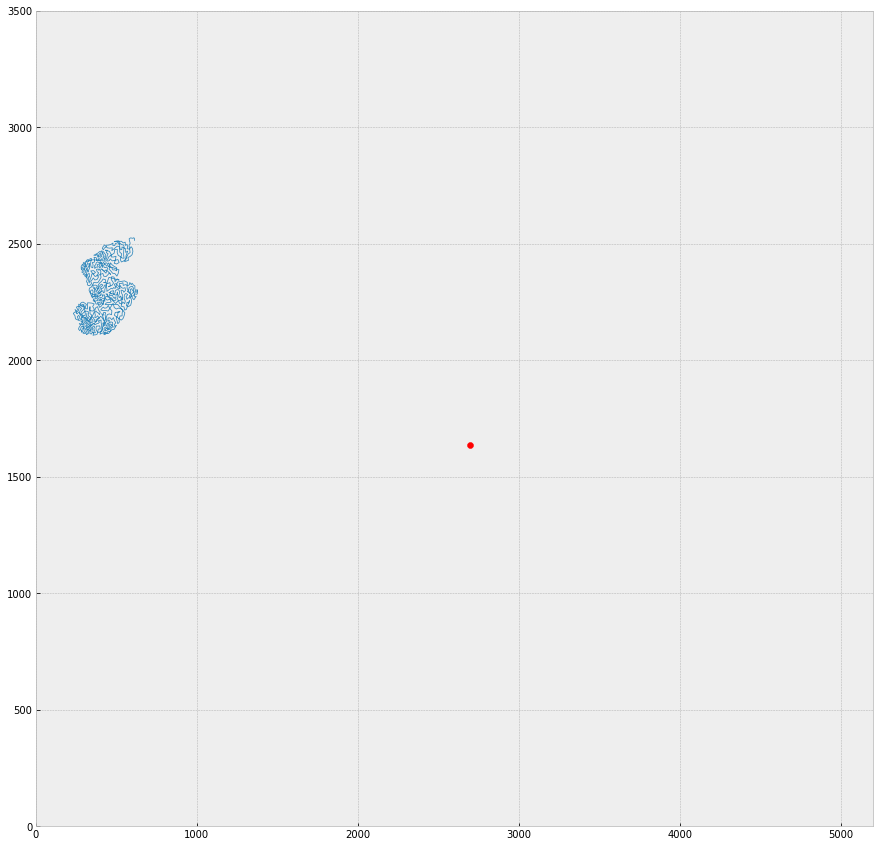

In [81]:
steps = cluster_steps[:1000]

full_xs = [full_dict[i][0] for i in steps]
full_ys = [full_dict[i][1] for i in steps]

end = None

start = 36

fig, ax = plt.subplots(figsize = (15,15))
ax.plot(full_xs[:end],full_ys[:end], alpha =1, linewidth=.8)
plt.scatter(full_data_dict[start][0], full_data_dict[start][1], color= 'r')
ax.set_xlim(0,5200)
ax.set_ylim(0,3500);

In [40]:
full_data_dict[0]

(316.83673906150904, 2202.34070733524)

In [41]:
len(ID[y > 2000])

95760

In [43]:
len(ID)

197769

In [42]:
prob_path_dist

1816114.9376446647

In [ ]:
pd.DataFrame({'Path':prob_steps}).to_csv('nearest_neighbor_cities.csv',index = False)